# Lassa data set evaluation

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def histograms(stats):
    # Creating histograms with custom labels
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))  # Adjust grid if you have a different layout

    stats[['N_share', 'Length', 'RelativeLength', 'RelativeError']].hist(
        bins=50, log=True, ax=axes
    )

    # Setting y-axis label for the left column
    axes[0].set_ylabel('Number of sequences')

    axes[0].set_xlim(0, 1)
    axes[1].set_xlim(left=0)
    axes[2].set_xlim(left=0)
    axes[3].set_xlim(0, 1)

    # Setting x-axis labels with the feature names
    features = ['N_share', 'Length', 'RelativeLength', 'RelativeError']
    for ax, feature in zip(axes.flatten(), features):
        ax.set_xlabel(feature)
        ax.set_title('')  # Remove the title above each plot

    plt.tight_layout()
    plt.show()

# Parameters

In [3]:
fname_stats = ''
fname_sequences = ''
outdir = ''

minlen = 2000
max_n_share = 0.01
min_relative_length = 0.95
min_ref_cov = 0.9

In [4]:
# Parameters
fname_stats = "data/all/collected_stats.tsv"
fname_sequences = "/Volumes/DataCurate/CurationDatasets/Covid/CovidRVDB/covid_rvdb_v29.fasta"
outdir = "data/filtered"


## Data ingestion.

We compute the following features
- the relative length of the sequence compared to the reference
- edit distance in relation to the match length
- the amount of the reference covered by the alignment
- the amount of the query covered by the alignment

In [5]:
seqstats = pd.read_csv(fname_stats, sep='\t')
seqstats['RelativeLength'] = seqstats['Length'] / seqstats['ReferenceLength']
seqstats['RelativeError'] = seqstats['EditDistance'] / (seqstats['ReferenceEnd'] - seqstats['ReferenceStart'])
seqstats['ReferenceCoverage'] = (seqstats['ReferenceEnd'] - seqstats['ReferenceStart']) / seqstats['ReferenceLength']
seqstats['QueryCoverage'] = (seqstats['QueryEnd'] - seqstats['QueryStart']) / seqstats['Length']

seqstats

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
0,NC_045512.2,NC_045512.2,True,0,29903,0,29903,0,False,0.000000,29903,29903,Unsegmented,1.000000,0.000000,1.000000,1.000000
1,OW670701.1,NC_045512.2,True,25,29847,0,29738,157,False,0.000000,29742,29903,Unsegmented,0.994616,0.005265,0.997291,0.999866
2,OW670765.1,NC_045512.2,True,25,29847,0,29582,307,False,0.000000,29588,29903,Unsegmented,0.989466,0.010294,0.997291,0.999797
3,OX907035.1,NC_045512.2,True,54,29836,0,29714,425,False,0.009558,29714,29903,Unsegmented,0.993680,0.014270,0.995954,1.000000
4,OR552799.1,NC_045512.2,True,50,29828,0,29722,439,False,0.009353,29722,29903,Unsegmented,0.993947,0.014742,0.995820,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,OP395451.1,NC_045512.2,True,46,29832,0,29718,431,False,0.009792,29718,29903,Unsegmented,0.993813,0.014470,0.996087,1.000000
3499,OX943604.1,NC_045512.2,True,50,29827,50,29699,205,False,0.004299,29775,29903,Unsegmented,0.995719,0.006885,0.995786,0.995768
3500,OX943635.1,NC_045512.2,True,23,29805,0,29182,677,False,0.000000,29182,29903,Unsegmented,0.975889,0.022732,0.995954,1.000000
3501,OX943834.1,NC_045512.2,True,23,29789,0,29643,192,False,0.000000,29643,29903,Unsegmented,0.991305,0.006450,0.995419,1.000000


Overall length and N_share distribution before any filtering has happened.

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

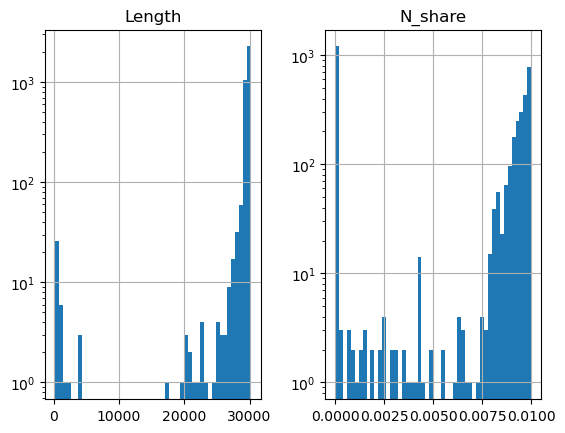

In [6]:
seqstats[['Length', 'N_share']].hist(bins=50, log=True)

## Removing unaligned sequences.

We remove all sequences that were not mapped. Let's have a look at the 10 largest sequences first.

In [7]:
unmapped = seqstats[seqstats['IsForward'].isna()][['Sequence', 'Length', 'N_share']]
print(f'Number of unmapped reads={len(unmapped)}')
unmapped.nlargest(10, ['Length'])

Number of unmapped reads=0


,Sequence,Length,N_share


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

/Users/nils.petersen/miniconda3/envs/bio/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


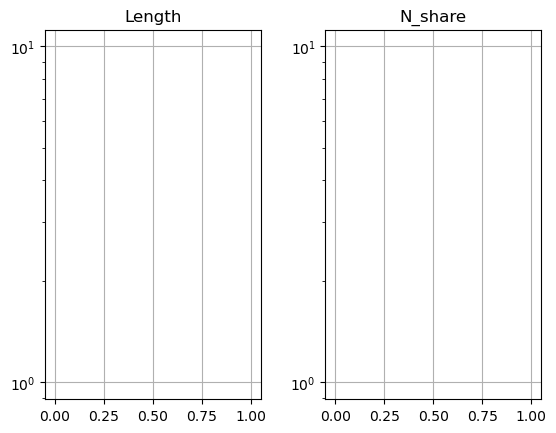

In [8]:
unmapped.hist(bins=20, log=True)

In [9]:
seqstats_mapped = seqstats.dropna(subset='Reference')

## Removing supplementary alignments

Additional to the best hit, minimap2 also sometimes computes supplementary alignments. We remove them here.

In [10]:
seqstats_primary = seqstats_mapped[seqstats_mapped['IsSupplementaryAlignment'] == False]

## Remove short sequences and those with too many Ns

In [11]:
seqstats_minlen = seqstats_primary[seqstats_primary['Length'] >= minlen]
seqstats_high_coverage = seqstats_minlen[seqstats_minlen['N_share'] <= max_n_share]

print('Before filtering:', len(seqstats_primary))
print(f'N-share larger than {max_n_share}:', len(seqstats_primary[seqstats_primary['N_share'] > max_n_share]))
print(f'Length smaller than {minlen}:', len(seqstats_primary[seqstats_primary['Length'] < minlen]))
print('After filtering:', len(seqstats_high_coverage))

Before filtering: 3501
N-share larger than 0.01: 0
Length smaller than 2000: 33
After filtering: 3468


## Remove too short genomes
We remove the genomes that are too short compared to the reference genome.

In [12]:
seqstats_long_seqs = seqstats_high_coverage[seqstats_high_coverage['RelativeLength'] > min_relative_length]
print(
    f'{len(seqstats_long_seqs)} of {len(seqstats_high_coverage)} sequences '
    f'remain after filtering for {min_relative_length} minimum relative length'
)

3382 of 3468 sequences remain after filtering for 0.95 minimum relative length


Additionally we remove all sequences, where the alignment does not cover enough of the target genome.

In [13]:
seqstats_long_seqs.nsmallest(10, ['ReferenceCoverage'])

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
387,OR559861.1,NC_045512.2,True,1012,29841,0,28773,442,False,0.009870,28773,29903,Unsegmented,0.962211,0.015332,0.964084,1.0
775,OP885408.1,NC_045512.2,True,863,29903,0,28980,426,False,0.009834,28980,29903,Unsegmented,0.969134,0.014669,0.971140,1.0
1378,OR366753.1,NC_045512.2,True,435,29544,0,29079,415,False,0.009801,29079,29903,Unsegmented,0.972444,0.014257,0.973447,1.0
2755,OM498757.1,NC_045512.2,True,551,29667,0,29041,438,False,0.009883,29041,29903,Unsegmented,0.971173,0.015043,0.973682,1.0
2937,OR456477.1,NC_045512.2,True,601,29733,0,29102,416,False,0.009896,29102,29903,Unsegmented,0.973213,0.014280,0.974217,1.0
3484,OQ621592.1,NC_045512.2,True,664,29836,0,29116,418,False,0.009273,29116,29903,Unsegmented,0.973682,0.014329,0.975554,1.0
477,PP824860.1,NC_045512.2,True,661,29840,0,29123,441,False,0.009649,29123,29903,Unsegmented,0.973916,0.015114,0.975788,1.0
2977,OP402200.1,NC_045512.2,True,551,29819,0,29209,418,False,0.009894,29209,29903,Unsegmented,0.976792,0.014282,0.978765,1.0
1034,OR725436.1,NC_045512.2,True,342,29665,0,29293,428,False,0.009968,29293,29903,Unsegmented,0.979601,0.014596,0.980604,1.0
1182,OR979376.1,NC_045512.2,True,342,29665,0,29293,427,False,0.009968,29293,29903,Unsegmented,0.979601,0.014562,0.980604,1.0


In [14]:
seqstats_min_ref_cov = seqstats_long_seqs[seqstats_long_seqs['ReferenceCoverage'] >= min_ref_cov]
print(f'Keeping {len(seqstats_min_ref_cov)} of {len(seqstats_long_seqs)} sequences')

Keeping 3382 of 3382 sequences


## Per reference genome counts
Let's have a look what is left after filtering with respect to the distinct reference genomes.

In [15]:
ref_counts_raw = seqstats_primary['Reference'].value_counts()
ref_counts_minlen = seqstats_minlen['Reference'].value_counts()
ref_counts_high_cov = seqstats_high_coverage['Reference'].value_counts()
ref_counts_filtered = seqstats_min_ref_cov['Reference'].value_counts()
pd.DataFrame({'Raw': ref_counts_raw, 'MinLen': ref_counts_minlen, 'MaxN': ref_counts_high_cov,  'Filtered': ref_counts_filtered})

,Raw,MinLen,MaxN,Filtered
Reference,,,,
NC_045512.2,3501,3468,3468,3382


## Statistics after filtering

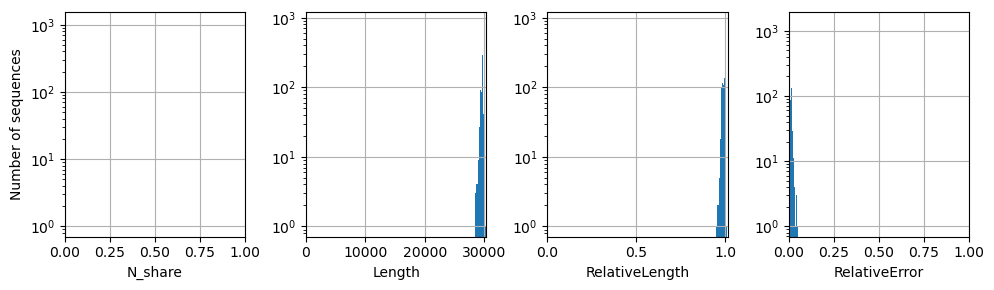

In [16]:
histograms(seqstats_min_ref_cov)

## Read orientation
Finally, lets get the filtered reads with harmonized orientation sorted into the Segments.

In [17]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

df_filtered_final = seqstats_min_ref_cov
os.makedirs(outdir, exist_ok=True)

segments = sorted(set(df_filtered_final['Segment'])) 
fname_template_out = os.path.join(outdir, "{}.fasta")

outfiles = {
    segment: open(fname_template_out.format(segment), 'w')
    for segment in segments
}

segment_and_orientation = {
    row['Sequence']: (row['IsForward'], row['Segment'])
    for _, row in df_filtered_final.iterrows()
}

for record in SeqIO.parse(fname_sequences, "fasta"):
    if record.id not in segment_and_orientation:
        continue
    is_forward, segment = segment_and_orientation[record.id]
    if is_forward is None:
        raise RuntimeError(f"Invalid orientation {is_forward}")
    orientation = 'forward' if is_forward else 'reverse'
    new_record = SeqRecord(
        seq=record.seq if is_forward else record.seq.reverse_complement(),
        id=record.id,
        name=record.name,
        description=f'{record.description}|{orientation}|{segment}'
    )
    SeqIO.write(new_record, outfiles[segment], "fasta")

for outfile in outfiles.values():
    outfile.close()